# WIP: Not Complete Yet
# World Development Indicators

This dataset contains the World Development Indicators from the World Bank, indicators measured annually to assess economic development from hundreds of countries around the world.

As the data comes as a SQLite database, I felt it would provide a good opportunity to practice and further:

- the SQL I have been learning recently,
- data manipulation and transformation using SQL instead of pandas,
- Matplotlib/Seaborn to create interesting data visualisations

Dataset sourced from Kaggle: https://www.kaggle.com/worldbank/world-development-indicators/version/2

#### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
sns.set_style('whitegrid')
sns.set_palette((sns.color_palette([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),                                  
 (0.1, 0.1, 0.1)])))

#### Selecting a colour palette - as we're looking at categorical data I am selecting a palette with distinct colours

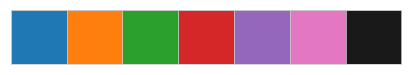

In [2]:
sns.palplot(sns.color_palette([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),                                  
 (0.1, 0.1, 0.1)]))

#### Connecting to SQLite DB
I could use the inbuilt cursor feature of the sqlite3 library to interact with the database but it is a little clunky, requiring for loops and printing the results of the query in a fairly unreadable format (one large string). I'll instead use Pandas' inbuilt read_sql() function to run queries as it outputs the data in a much nicer format.

In [3]:
#Connecting to DB
conn = sqlite3.connect("C:\Databases\World Development Indicators\database.sqlite")

In [4]:
#Investigating the format of our features and observations
pd.read_sql(
    """
    PRAGMA table_info(indicators)
    """,
    con=conn)

,cid,name,type,notnull,dflt_value,pk
0,0,CountryName,TEXT,0,None,0
1,1,CountryCode,TEXT,0,None,0
2,2,IndicatorName,TEXT,0,None,0
3,3,IndicatorCode,TEXT,0,None,0
4,4,Year,INTEGER,0,None,0
5,5,Value,NUMERIC,0,None,0


In [5]:
#6 features, how many rows?
pd.read_sql(
    """
    SELECT MAX(rowid) FROM indicators
    """,
    con=conn)

,MAX(rowid)
0,5656458


In [6]:
#In the indicators table, there are 5.66m rows containing data from 1300+ indicators.
#I'm going to export the unique indicators to a CSV for manual review of which to investigate.
pd.read_sql(
    """
    SELECT DISTINCT IndicatorCode, IndicatorName
    FROM indicators
    """,
    con=conn).to_csv('Indicator List.csv')

## 1) How has electricity consumption and production changed over the last 4 decades?

In [7]:
#Creating our subset of the data, selecting interesting indicators and these regions of the globe: 
#'East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World'
electricity = pd.read_sql(
    """
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN ('EG.ELC.FOSL.ZS',
            'EG.ELC.HYRO.ZS',
            'EG.ELC.NUCL.ZS',
            'EG.ELC.RNWX.ZS',
            'EG.FEC.RNEW.ZS',
            'EG.USE.COMM.FO.ZS',
            'EG.USE.ELEC.KH.PC') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [8]:
#Seperating our electricity dataframe in to individual dataframes for each indicator, as objects within a dictionary so we can iterate through them easily
electricity_dict = {}
for i in electricity.IndicatorCode.unique():
    electricity_dict[i] = electricity[electricity.IndicatorCode == i]

Text(0,0.5,'kWh per capita')

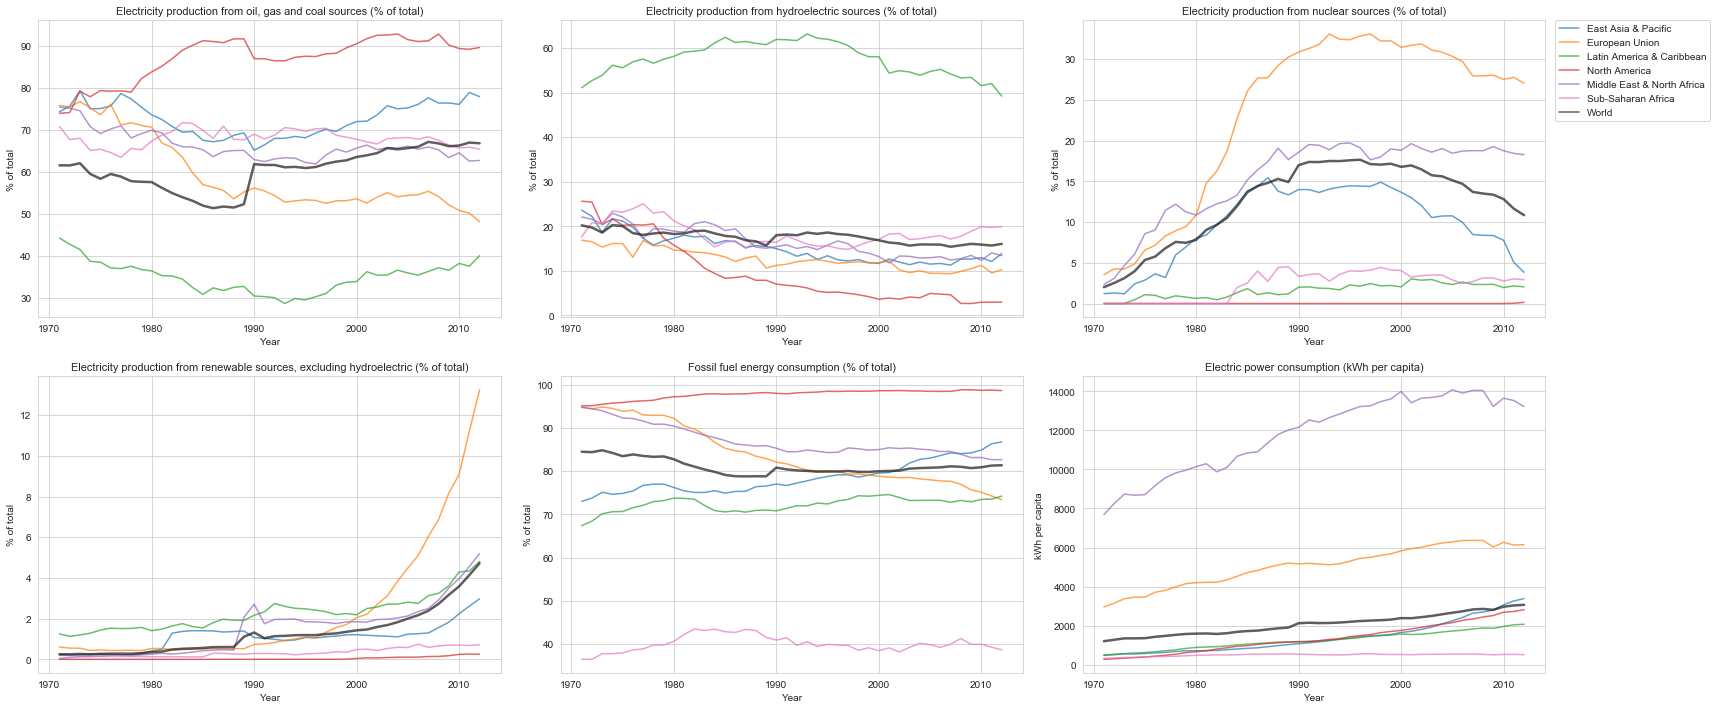

In [9]:
#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (27,12),gridspec_kw={'wspace':0.13})
#Index variable to allow iteration through the dictionary
ind = -1
for i in electricity.IndicatorCode.unique():
    ind +=1
    if ind < 3:
        #First row of graphs
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=electricity_dict[i],ax=axes[0][ind])
        #Pulling title from IndicatorName field
        axes[0][ind].set_title(str(electricity_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        axes[0][ind].get_legend().remove()
        #Setting y labels for graphs
        axes[0][ind].set_ylabel('% of total')
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[0][ind].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[0][ind].lines:
            plt.setp(l,alpha=.70)
        
    elif ind < 6:
        #Second row of graphs
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=electricity_dict[i],ax=axes[1][ind-3])
        #Pulling title from IndicatorName field
        axes[1][ind-3].set_title(str(electricity_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        axes[1][ind-3].get_legend().remove()
        #Setting y labels for graphs    
        axes[1][ind-3].set_ylabel('% of total')
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[1][ind-3].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[1][ind-3].lines:
            plt.setp(l,alpha=.70)
    else:
        break
        
#Creating patches for labels
handles, labels = axes[0][2].get_legend_handles_labels()
#Skipping first value as we do not want the legend title
handles= handles[1:]
#Setting label values
labels = ['East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World']
#Setting legend position on graph
axes[0][2].legend(handles,labels,bbox_to_anchor=(1.01, 1.017))
#Setting unique y label value
axes[1][2].set_ylabel('kWh per capita')

Discussion and analysis

## 2) How have CO2 emissions changed over the last 4 decades? Are there any increases or decreases in particular areas or industries?

In [10]:
#Creating our subset of the data, selecting interesting indicators and these regions of the globe: 
#'East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World'
atmosphere = pd.read_sql(
    """
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN (
            'EN.ATM.CO2E.PC',
            'EN.CO2.BLDG.ZS',
            'EN.CO2.ETOT.ZS',
            'EN.CO2.MANF.ZS',
            'EN.CO2.TRAN.ZS',
            'EN.ATM.METH.EG.ZS') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [11]:
#Seperating our atmosphere dataframe in to individual dataframes for each indicator, as objects within a dictionary so we can iterate through them easily
atmosphere_dict = {}
for i in atmosphere.IndicatorCode.unique():
    atmosphere_dict[i] = atmosphere[atmosphere.IndicatorCode == i]

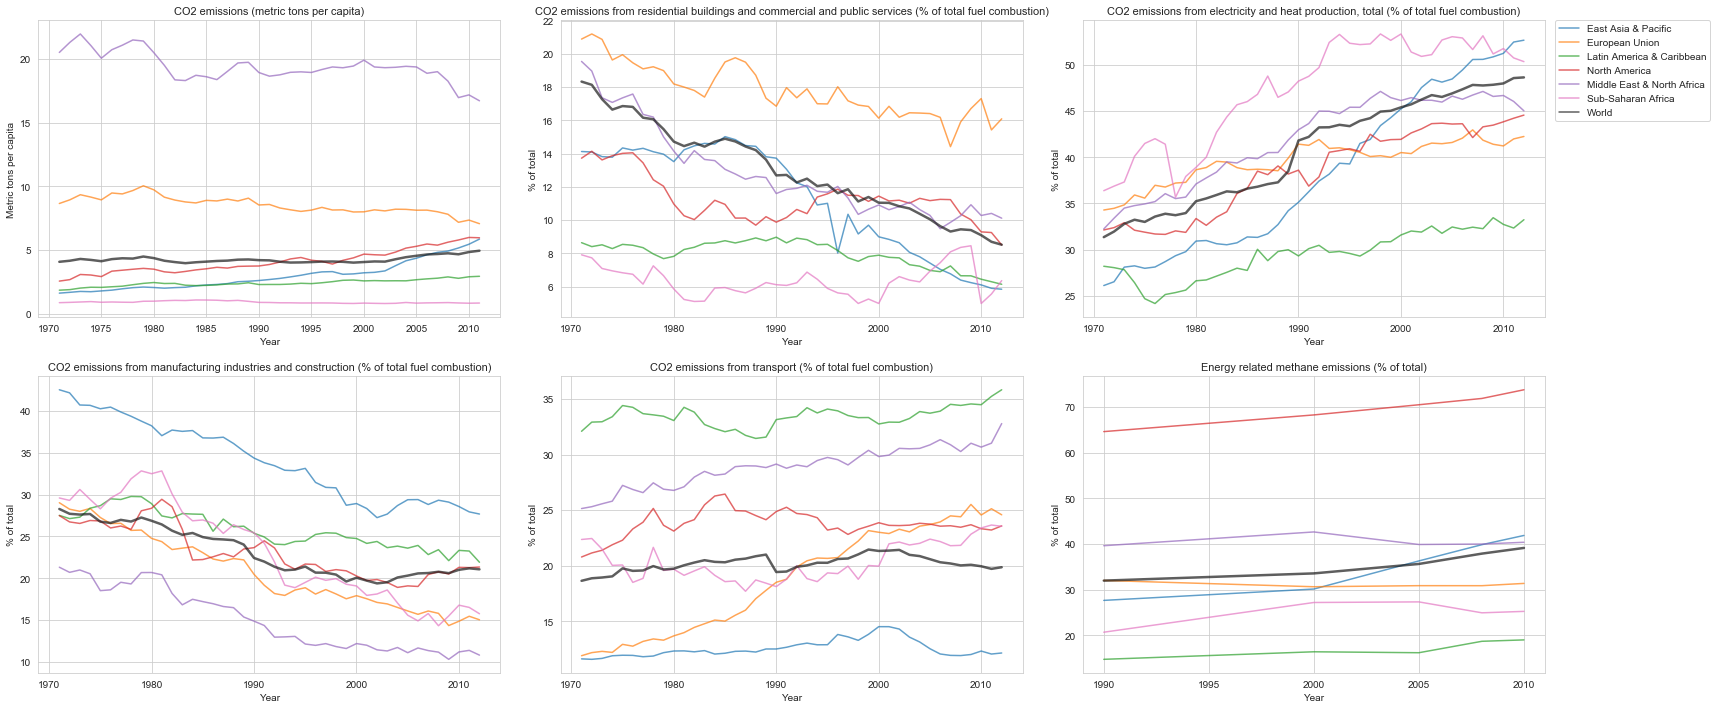

In [12]:
#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (27,12),gridspec_kw={'wspace':0.13})
#Index variable to allow iteration through the dictionary
ind = -1
for i in atmosphere.IndicatorCode.unique():
    ind +=1
    if ind < 3:
        #First row of graphs
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=atmosphere_dict[i],ax=axes[0][ind])
        #Pulling title from IndicatorName field
        axes[0][ind].set_title(str(atmosphere_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        axes[0][ind].get_legend().remove()
        #Setting y labels for graphs
        axes[0][ind].set_ylabel('% of total')
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[0][ind].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[0][ind].lines:
            plt.setp(l,alpha=.70)
        
    elif ind < 6:
        #Second row of graphs
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=atmosphere_dict[i],ax=axes[1][ind-3])
        #Pulling title from IndicatorName field
        axes[1][ind-3].set_title(str(atmosphere_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        axes[1][ind-3].get_legend().remove()
        #Setting y labels for graphs    
        axes[1][ind-3].set_ylabel('% of total')
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[1][ind-3].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[1][ind-3].lines:
            plt.setp(l,alpha=.70)
    else:
        break
        
#Creating patches for labels
handles, labels = axes[0][2].get_legend_handles_labels()
#Skipping first value as we do not want the legend title
handles= handles[1:]
#Setting label values
labels = ['East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World']
#Setting legend position on graph
axes[0][2].legend(handles,labels,bbox_to_anchor=(1.01, 1.017))
#Setting unique y label values
axes[0][0].set_ylabel('Metric tons per capita')
#Setting x ticks to avoid half-year values
axes[1][2].set_xticks(range(1990,2015,5))
plt.show()

Discussion and analysis

## 2) How has the health of the world changed?

For this analysis I'm going to be collapsing 2 different groups of indexes in to a single value:

The below will be collapsed in to a single index - 'Average physicians, nurses and hospital beds (per 1,000 people)' - this is to condense data that presents very similar information - access to healthcare, and also to get the most amount of data for this information as not every measure has been recorded for each area each year.
- Hospital beds (per 1,000 people)
- Nurses and midwives (per 1,000 people)
- Physicians (per 1,000 people)

The below will be collapsed in to a single index - 'Smoking prevalence (% of adults)' - again, condensing data that provides very similar information, and allows us to create a single graph to show smoking prevalence.
- Smoking prevalence, females (% of adults)
- Smoking prevalence, males (% of adults)


In [13]:
health = pd.read_sql(
    """
    SELECT CountryName,CountryCode,'Average physicians, nurses and hospital beds (per 1,000 people)'  as IndicatorName,'SH.MED.PNHB.ZS' as IndicatorCode,Year,AVG(Value) as Value FROM indicators
    WHERE 
        IndicatorCode IN (
        'SH.MED.BEDS.ZS',
        'SH.MED.NUMW.P3',
        'SH.MED.PHYS.ZS') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    GROUP BY CountryName,Year
    UNION ALL
    SELECT CountryName,CountryCode,'Smoking prevalence (% of adults)'  as IndicatorName,'SH.PRV.SMOK.AD' as IndicatorCode,Year,AVG(Value) FROM indicators
    WHERE 
        IndicatorCode IN (
        'SH.PRV.SMOK.FE',
        'SH.PRV.SMOK.MA') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    GROUP BY CountryName,Year    
    UNION ALL
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN (
        'SH.STA.MALN.ZS',
        'SH.STA.OWGH.ZS',
        'SH.XPD.TOTL.ZS') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [14]:
#Seperating our health dataframe in to individual dataframes for each indicator, as objects within a dictionary so we can iterate through them easily
health_dict = {}
for i in health.IndicatorCode.unique():
    health_dict[i] = health[health.IndicatorCode == i]

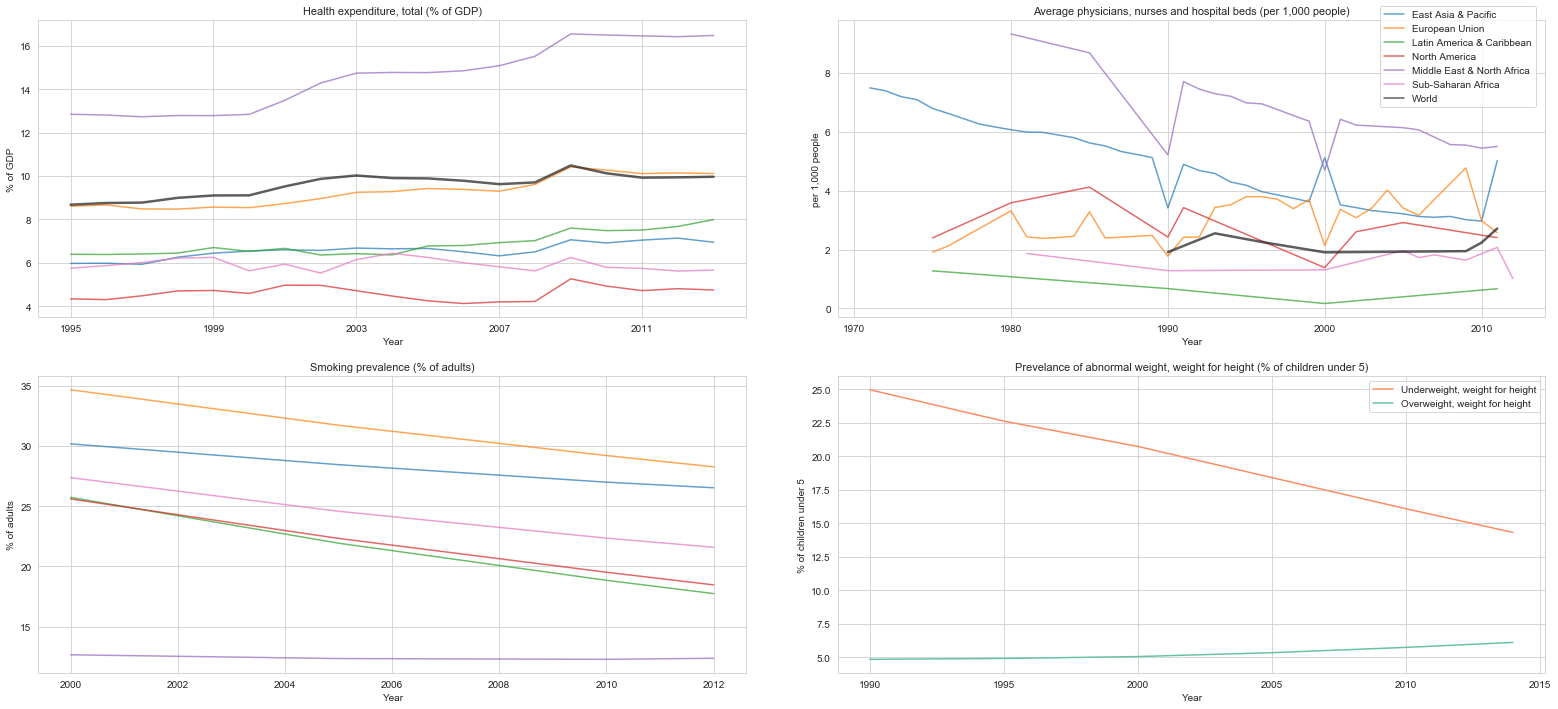

In [15]:
#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (27,12),gridspec_kw={'wspace':0.13})
#Index variable to allow iteration through the dictionary
ind = -1
#As the final graph only contains world values, using custom list of IndicatorCodes to order the graphs correctly
for i in ['SH.XPD.TOTL.ZS','SH.MED.PNHB.ZS','SH.PRV.SMOK.AD','SH.STA.OWGH.ZS','SH.STA.MALN.ZS']:
    ind +=1
    if ind < 2:
        #First row of graphs
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=health_dict[i],ax=axes[0][ind])
        #Pulling title from IndicatorName field
        axes[0][ind].set_title(str(health_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        axes[0][ind].get_legend().remove()
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[0][ind].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[0][ind].lines:
            plt.setp(l,alpha=.70)
        
    elif ind == 2:
        #Bottom left graph
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=health_dict[i],ax=axes[1][ind-2])
        #Pulling title from IndicatorName field
        axes[1][ind-2].set_title(str(health_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        axes[1][ind-2].get_legend().remove()
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[1][ind-2].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[1][ind-2].lines:
            plt.setp(l,alpha=.70)

    elif ind < 5:
        #Bottom right graph, plotting the underweight and overweight values on the same graph
        sns.lineplot(x='Year',y='Value',data=health_dict[i],label=['Overweight, weight for height','Underweight, weight for height'][ind-3],color=sns.color_palette("Set2", 2)[ind-3],ax=axes[1][1])
        #Setting bottom right graph title
        axes[1][1].set_title('Prevelance of abnormal weight, weight for height (% of children under 5)',fontsize=11)
        #Creating the legend for bottom right axis, reversing order to match order of lines
        handles, labels = axes[1][1].get_legend_handles_labels()
        axes[1][1].legend(handles[::-1],labels[::-1])
        
    else:
        break
        
#Creating patches for labels
handles, labels = axes[0][1].get_legend_handles_labels()
#Skipping first value as we do not want the legend title
handles= handles[1:]
#Setting legend label values
labels = ['East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World']
#Adding the legend to top right graph
axes[0][1].legend(handles,labels, bbox_to_anchor=(0.76, 0.69))
#Setting unique y label values
axes[0][0].set_ylabel('% of GDP')
axes[0][1].set_ylabel('per 1,000 people')
axes[1][0].set_ylabel('% of adults')
axes[1][1].set_ylabel('% of children under 5')
#Setting x ticks for top left graph to replace decimal year values automatically generated
axes[0][0].set_xticks(range(1995,2015,4))

plt.show()

Discussion and analysis

In [16]:
lifespan = pd.read_sql(
    """
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN (
        'SP.DYN.AMRT.FE',
        'SP.DYN.AMRT.MA',
        'SP.DYN.TO65.FE.ZS',
        'SP.DYN.TO65.MA.ZS') AND 
        CountryCode IN ('NAC','EAS','EUU','LCN','MEA','SSF','WLD') AND
        Year > 1970
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [17]:
lifespan_dict = {}
for i in lifespan.IndicatorCode.unique():
    lifespan_dict[i] = lifespan[lifespan.IndicatorCode == i]

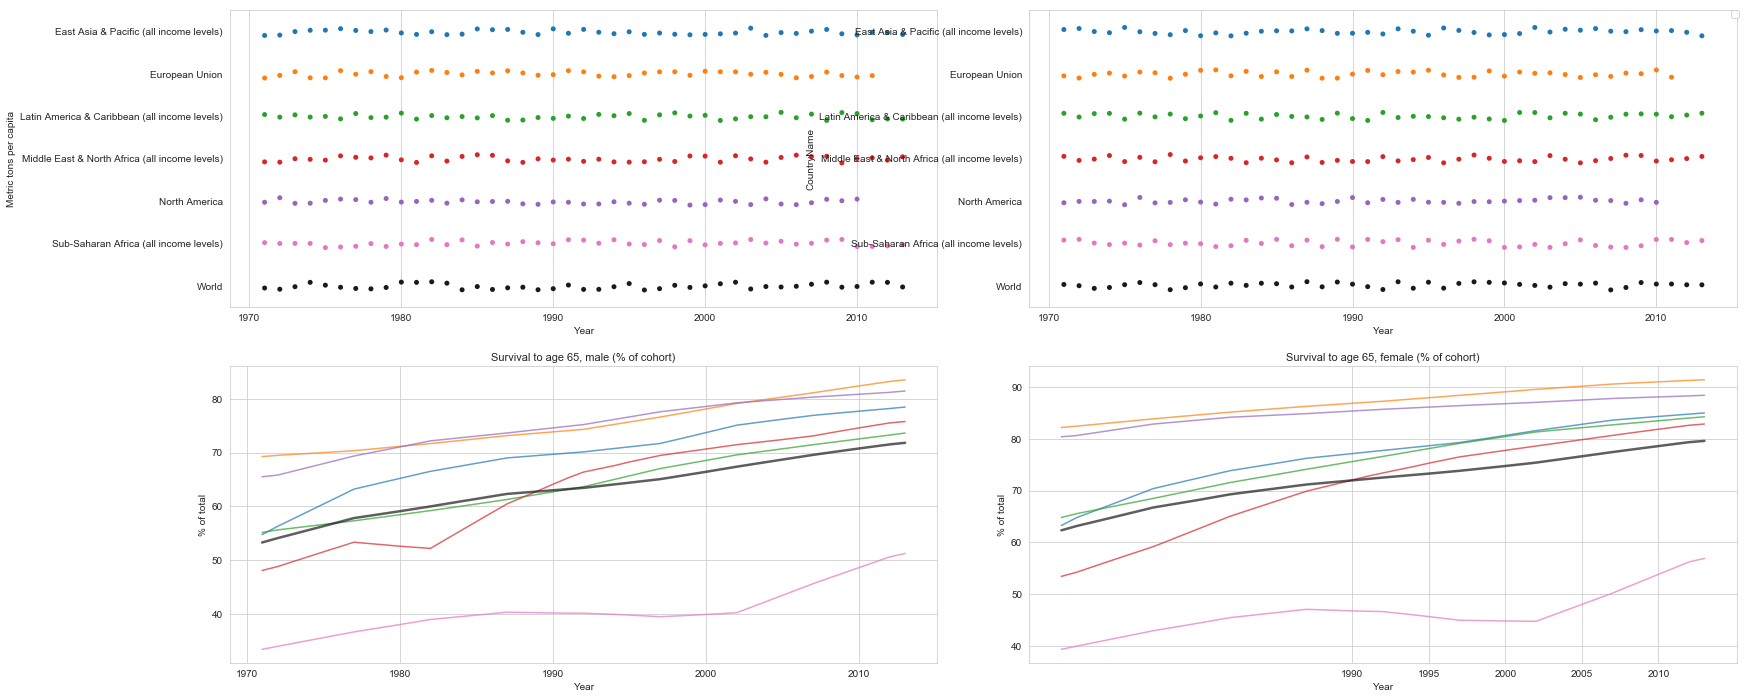

In [18]:

#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (27,12),gridspec_kw={'wspace':0.13})
#Index variable to allow iteration through the dictionary
ind = -1
for i in lifespan.IndicatorCode.unique():
    ind +=1
    if ind < 2:
        #First row of graphs
        sns.stripplot(x='Year',y='CountryName',data=lifespan_dict[i],ax=axes[0][ind])
        #Pulling title from IndicatorName field
        #axes[0][ind].set_title(str(lifespan_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        #axes[0][ind].get_legend().remove()
        #Setting y labels for graphs
        #axes[0][ind].set_ylabel('% of total')
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        #plt.setp(axes[0][ind].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        #for l in axes[0][ind].lines:
            #plt.setp(l,alpha=.70)
        
    elif ind < 4:
        #Second row of graphs
        sns.lineplot(x='Year',y='Value',hue='CountryName',data=lifespan_dict[i],ax=axes[1][ind-3])
        #Pulling title from IndicatorName field
        axes[1][ind-3].set_title(str(lifespan_dict[i]['IndicatorName'].unique())[2:-2],fontsize=11)
        #Removing legend to allow for a single common legend
        axes[1][ind-3].get_legend().remove()
        #Setting y labels for graphs    
        axes[1][ind-3].set_ylabel('% of total')
        #Making the line for World value bolder to allow easy identification of global direction on indicator
        plt.setp(axes[1][ind-3].lines[6],linewidth=2.5)
        #Setting the line alpha as there's no way to set the alpha level on the colour palette
        for l in axes[1][ind-3].lines:
            plt.setp(l,alpha=.70)
    else:
        break
        
#Creating patches for labels
handles, labels = axes[0][1].get_legend_handles_labels()
#Skipping first value as we do not want the legend title
handles= handles[1:]
#Setting label values
labels = ['East Asia & Pacific', 'European Union', 'Latin America & Caribbean', 'North America','Middle East & North Africa', 'Sub-Saharan Africa', 'World']
#Setting legend position on graph
axes[0][1].legend(handles,labels,bbox_to_anchor=(1.01, 1.017))
#Setting unique y label values
axes[0][0].set_ylabel('Metric tons per capita')
#Setting x ticks to avoid half-year values
axes[1][1].set_xticks(range(1990,2015,5))
plt.show()

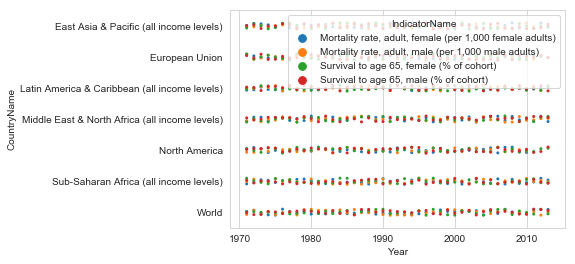

In [19]:
sns.stripplot(x='Year',y='CountryName',hue='IndicatorName',size=3,data=lifespan)

SyntaxError: invalid syntax (<ipython-input-20-3cf2e198998d>, line 3)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12,12),gridspec_kw={'wspace':0.13})

for row in range(len(lifespan[lifespan['IndicatorCode']=='SP.DYN.TO65.FE.ZS'])):
    axes.scatter(x='Year',y='CountryName',s='Value',data=lifespan[lifespan['IndicatorCode']=='SP.DYN.TO65.FE.ZS'].iloc[row])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12,12),gridspec_kw={'wspace':0.13})

axes.scatter(x='Year',y='CountryName',s=lifespan[lifespan['IndicatorCode']=='SP.DYN.TO65.FE.ZS']['Value']*4,data=lifespan[lifespan['IndicatorCode']=='SP.DYN.TO65.FE.ZS'])

In [ ]:
axes.scatter(x='Year',y='CountryName',s='Value',data=lifespan[lifespan['IndicatorCode']=='SP.DYN.TO65.FE.ZS'].iloc[0])

In [ ]:
lifespan[lifespan['IndicatorCode']=='SP.DYN.TO65.FE.ZS'].iloc[0]['Value']

In [ ]:
float(lifespan[lifespan['IndicatorCode']=='SP.DYN.TO65.FE.ZS'].iloc[0]['Value'])

In [ ]:
'SP.POP.0014.TO.ZS',
'SP.POP.1564.TO.ZS',
'SP.POP.65UP.TO.ZS'


## 2) How have CO2 emissions changed over the last 4 decades? Are there any increases or decreases in particular areas or industries?

In [21]:
popspread = pd.read_sql(
    """
    SELECT indicators.* FROM indicators
    WHERE 
        IndicatorCode IN (
        'SP.POP.0014.TO.ZS',
        'SP.POP.1564.TO.ZS',
        'SP.POP.65UP.TO.ZS',
        'SP.RUR.TOTL.ZS',
        'SP.URB.TOTL.IN.ZS') AND 
        CountryCode IN ('WLD') 
        
    
    ORDER BY Year,IndicatorCode,CountryCode
    """,
    con=conn
)

In [22]:
#Creating our 3 x N array for the stackplot using list comprehension and np.vstack operation
yage = np.vstack([[popspread[popspread['IndicatorCode']==i]['Value']] for i in ['SP.POP.0014.TO.ZS','SP.POP.1564.TO.ZS','SP.POP.65UP.TO.ZS']])
#Creating our x values for year
xage = popspread[popspread['IndicatorCode']=='SP.POP.0014.TO.ZS']['Year']

#Creating our 2 x N array for the stackplot using list comprehension and np.vstack operation
yloc = np.vstack([[popspread[popspread['IndicatorCode']==i]['Value']] for i in ['SP.RUR.TOTL.ZS','SP.URB.TOTL.IN.ZS']])
#Creating our x values for year
xloc = popspread[popspread['IndicatorCode']=='SP.URB.TOTL.IN.ZS']['Year']

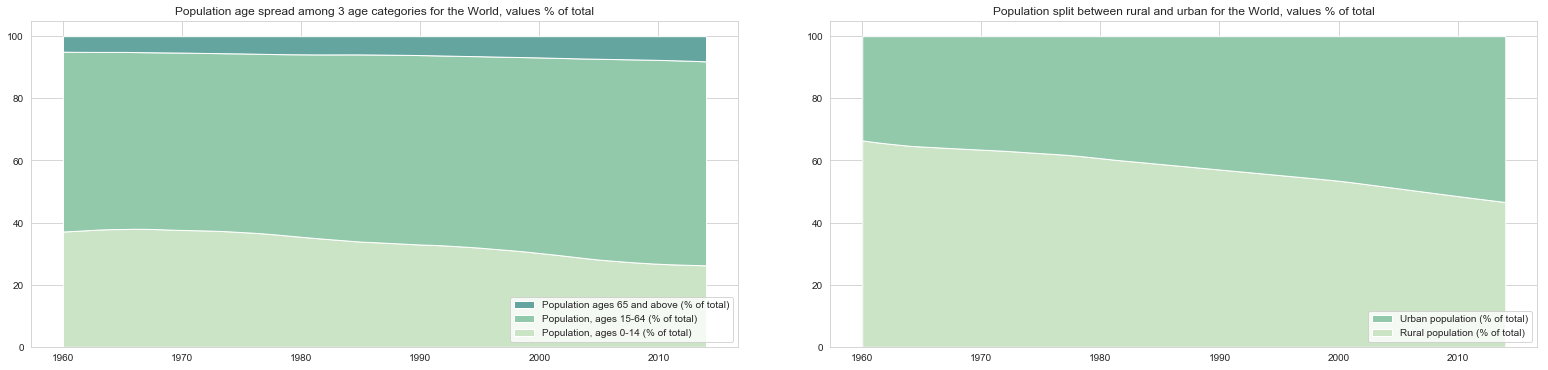

In [23]:
#Creating the subplots objects to graph on to
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (27,6),gridspec_kw={'wspace':0.13})
agelabels = ['Population, ages 0-14 (% of total)','Population, ages 15-64 (% of total)','Population ages 65 and above (% of total)']
axes[0].stackplot(xage,yage,labels=agelabels,colors=sns.cubehelix_palette(6, start=.5, rot=-.65))
axes[0].set_title('Population age spread among 3 age categories for the World, values % of total')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1],labels[::-1],loc=4)



loclabels = ['Rural population (% of total)', 'Urban population (% of total)']
axes[1].stackplot(xloc,yloc,labels=loclabels,colors=sns.cubehelix_palette(6, start=.5, rot=-.65))
axes[1].set_title('Population split between rural and urban for the World, values % of total')
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[::-1],labels[::-1],loc=4)

Discussion and analysis

In [ ]:
pd.read_sql(
    """

    SELECT *
    FROM indicators
    WHERE 
        IndicatorCode IN ('SI.POV.GINI')

    

    """,
    con=conn
)

In [4]:
#To create my dataframe for this analysis I will select the indicators I want to use, and then use inner joins
#to condense the table and lign up the columns based on Year and Country. This creates a more memory efficient table 
#and allows for easy graphing
wealthdisparity = pd.read_sql(
    """

    SELECT  A.CountryName as 'Country Name', A.[Year], A.Value AS 'Income held by top 20%',
            B.Value AS 'Income held by bottom 20%',
            C.Value AS 'GINI Index'
            
    FROM indicators A
        
    INNER JOIN indicators B ON
    A.[Year] = B.[Year] AND A.CountryName = B.CountryName AND A.IndicatorName != B.IndicatorName
    
    INNER JOIN indicators C ON
    
    A.[Year] = C.[Year] AND A.CountryName = C.CountryName

    WHERE A.IndicatorName = 'Income share held by highest 20%' AND B.IndicatorName = 'Income share held by lowest 20%' AND C.IndicatorName = 'GINI index (World Bank estimate)'


    """,
    con=conn
)

In [33]:
wealthdisparity['Country Name'].unique()

array(['Australia', 'Brazil', 'Canada', 'China', 'Costa Rica', 'Ethiopia',
       'Thailand', 'Uruguay', 'Venezuela, RB', 'Bangladesh', 'India',
       'Indonesia', 'Malaysia', 'Mexico', 'Morocco', 'Nepal', 'Rwanda',
       'Botswana', "Cote d'Ivoire", 'Nigeria', 'Philippines', 'Poland',
       'Sri Lanka', 'Tunisia', 'Argentina', 'Dominican Republic',
       'Guatemala', 'Honduras', 'Iran, Islamic Rep.', 'Israel', 'Jordan',
       'Lesotho', 'United States', 'Chile', 'Ecuador', 'Ghana', 'Hungary',
       'Mauritania', 'Pakistan', 'Slovenia', 'Turkey', 'Belarus',
       'Colombia', 'Croatia', 'Czech Republic', 'Estonia', 'Jamaica',
       'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova',
       'Russian Federation', 'Slovak Republic', 'Trinidad and Tobago',
       'Turkmenistan', 'Ukraine', 'Uzbekistan', 'Bulgaria', 'Panama',
       'Romania', 'Uganda', 'Bolivia', 'Paraguay', 'El Salvador',
       'Guinea', 'Senegal', 'Tanzania', 'Zambia', 'Burundi',
       'Central Af

These indexes do not include the continent-like combined values for the countries so I will need to condense the data down manually. 

#### Step 1) Export the country list for this dataframe to a csv file

In [29]:
pd.read_sql(
    """
    SELECT DISTINCT(CountryName)
    FROM indicators
    """,
    con=conn
).to_csv('CountryList.csv')

#### Step 2) Locate a datasource for the list of countries in each continent

I will be using https://www.worldatlas.com/cntycont.htm

#### Step 3) Use VLOOKUP to match the values in the list from 2) to the list from 1)

Manually amend the discrepenancies in country name between Column C (which was a copy of Column B, names from website) and Column E (names from dataframe). VLOOKUP in column F used to find these. See Countries.xlsx for worksheet.

#### Step 4) Import the country list and select only columns wanted

In [5]:
countries = pd.read_csv('Countries.csv')
countries = countries[['Country List Grouped By Continent','Continent']]
countries.columns = ['Country','Continent']
countries.head(3)

,Country,Continent
0,Algeria,Africa
1,Angola,Africa
2,Benin,Africa


In [32]:
#Pairing the countries with their continents
wealthdisparity['Continent'] = wealthdisparity['Country Name'].apply(lambda x: str(countries[countries['Country'] == x]['Continent'].values)[2:-2])

In [33]:
wealthdisparity.head(3)

,Country Name,Year,Income held by top 20%,Income held by bottom 20%,GINI Index,Continent
0,Australia,1981,39.17,7.67,31.33,Oceania
1,Brazil,1981,62.29,2.68,57.93,South America
2,Canada,1981,39.99,7.14,32.60,North America


In [39]:
#Are there any countires which have not been mapped?
wealthdisparity[wealthdisparity['Continent']=='']['Country Name'].unique()

array(['Kosovo', 'West Bank and Gaza'], dtype=object)

In [41]:
#Dropping these
wealthdisparity = wealthdisparity[wealthdisparity['Continent']!='']
#Checking none remaining
wealthdisparity[wealthdisparity['Continent']=='']['Country Name'].unique()

array([], dtype=object)

My original plan for these indexes was to plot the relationship of 'Income held by top 20%' vs 'Income held by bottom 20%' for each country for each year, and label the start and end points to see how the relationship has changed over time. However, upon plotting this I observed a number of problems:

1) 

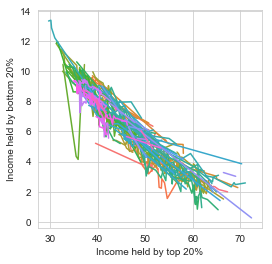

In [168]:
plt.figure(figsize=(4,4))
sns.lineplot(x='Income held by top 20%',y='Income held by bottom 20%',hue='Country Name',legend=False,data=wealthdisparity)

In [61]:
#Creating mean table
wealthmean = wealthdisparity.groupby(['Year','Continent'],as_index=False).mean()
wealthmean['Type'] = 'Mean'
wealthmean.head()

,Year,Continent,Income held by top 20%,Income held by bottom 20%,GINI Index,Type
0,1981,Africa,41.310000,8.560000,32.420000,Mean
1,1981,Asia,44.670000,7.050000,37.165000,Mean
2,1981,North America,45.690000,5.245000,40.045000,Mean
3,1981,Oceania,39.170000,7.670000,31.330000,Mean
4,1981,South America,57.116667,3.586667,52.396667,Mean


In [60]:
#Creating max table
wealthmax = wealthdisparity.groupby(['Year','Continent'],as_index=False).max().drop('Country Name',axis=1)
wealthmax['Type'] = 'Max'
wealthmax.head()

,Year,Continent,Income held by top 20%,Income held by bottom 20%,GINI Index,Type
0,1981,Africa,41.31,8.56,32.42,Max
1,1981,Asia,51.40,8.68,45.22,Max
2,1981,North America,51.39,7.14,47.49,Max
3,1981,Oceania,39.17,7.67,31.33,Max
4,1981,South America,62.29,4.98,57.93,Max


In [62]:
#Creating min table
wealthmin = wealthdisparity.groupby(['Year','Continent'],as_index=False).min().drop('Country Name',axis=1)
wealthmin['Type'] = 'Min'
wealthmin.head()

,Year,Continent,Income held by top 20%,Income held by bottom 20%,GINI Index,Type
0,1981,Africa,41.31,8.56,32.42,Min
1,1981,Asia,37.94,5.42,29.11,Min
2,1981,North America,39.99,3.35,32.60,Min
3,1981,Oceania,39.17,7.67,31.33,Min
4,1981,South America,49.19,2.68,43.65,Min


In [64]:
wealth = pd.concat([wealthmean,wealthmax,wealthmin]).sort_values(['Year','Continent'])

In [156]:
ab20 = np.vstack([[i[i['Continent']=='Africa']['Income held by bottom 20%'] for i in [wealthmin,wealthmean,wealthmax]]])

In [157]:
ab20[1] = ab20[1]-ab20[0]
ab20[2] = ab20[2]-ab20[1]-ab20[0]

In [158]:
ab20

array([[8.56      , 6.58      , 3.59      , 2.87      , 4.23      ,
        6.81      , 4.94      , 5.87      , 0.94      , 1.99      ,
        2.95      , 1.51      , 2.32      , 3.66      , 3.85      ,
        4.31      , 5.7       , 3.06      , 4.15      , 2.27      ,
        3.02      , 3.55      , 4.54      , 2.58      , 4.97      ,
        2.6       , 2.84      , 2.84      , 2.47      , 4.27      ],
       [0.        , 1.555     , 1.435     , 2.01      , 1.59666667,
        0.09      , 0.        , 0.35      , 3.284     , 3.28285714,
        1.51      , 3.105     , 3.385     , 1.684     , 1.25333333,
        1.12571429, 1.0625    , 2.41222222, 1.454     , 3.04444444,
        2.51625   , 2.43166667, 1.132     , 3.26571429, 1.33428571,
        2.73142857, 2.52125   , 2.86666667, 3.54666667, 1.902     ],
       [0.        , 1.555     , 0.995     , 2.01      , 1.14333333,
        0.09      , 0.        , 0.35      , 2.796     , 2.66714286,
        1.52      , 1.845     , 1.255     , 1.

In [108]:
ab20 = np.vstack([[i[i['Continent']=='Africa']['Income held by bottom 20%'] for i in [wealthmean,wealthmax,wealthmin]]])
#Creating our x values for year
xwealth = wealthmean[wealthmean['Continent']=='Africa']['Year']

In [110]:
ywealth

array([[8.56      , 8.135     , 5.025     , 4.88      , 5.82666667,
        6.9       , 4.94      , 6.22      , 4.224     , 5.27285714,
        4.46      , 4.615     , 5.705     , 5.344     , 5.10333333,
        5.43571429, 6.7625    , 5.47222222, 5.604     , 5.31444444,
        5.53625   , 5.98166667, 5.672     , 5.84571429, 6.30428571,
        5.33142857, 5.36125   , 5.70666667, 6.01666667, 6.172     ],
       [8.56      , 9.69      , 6.02      , 6.89      , 6.97      ,
        6.99      , 4.94      , 6.57      , 7.02      , 7.94      ,
        5.98      , 6.46      , 6.96      , 6.82      , 6.09      ,
        6.53      , 9.12      , 7.92      , 6.56      , 7.25      ,
        6.98      , 9.38      , 6.98      , 8.92      , 7.7       ,
        9.25      , 7.97      , 8.38      , 8.93      , 7.56      ],
       [8.56      , 6.58      , 3.59      , 2.87      , 4.23      ,
        6.81      , 4.94      , 5.87      , 0.94      , 1.99      ,
        2.95      , 1.51      , 2.32      , 3.

In [83]:
sns.light_palette("navy")[2:4]

[array([0.54      , 0.54      , 0.80078431, 1.        ]),
 array([0.36      , 0.36      , 0.70117647, 1.        ])]

In [137]:
(sns.light_palette("navy")[5])

array([0.        , 0.        , 0.50196078, 1.        ])

In [143]:
sns.diverging_palette(255, 133, l=60, n=7, center="dark")[1]

array([0.30805275, 0.41387686, 0.63067239, 1.        ])

In [166]:
axes.lines

[None, None]

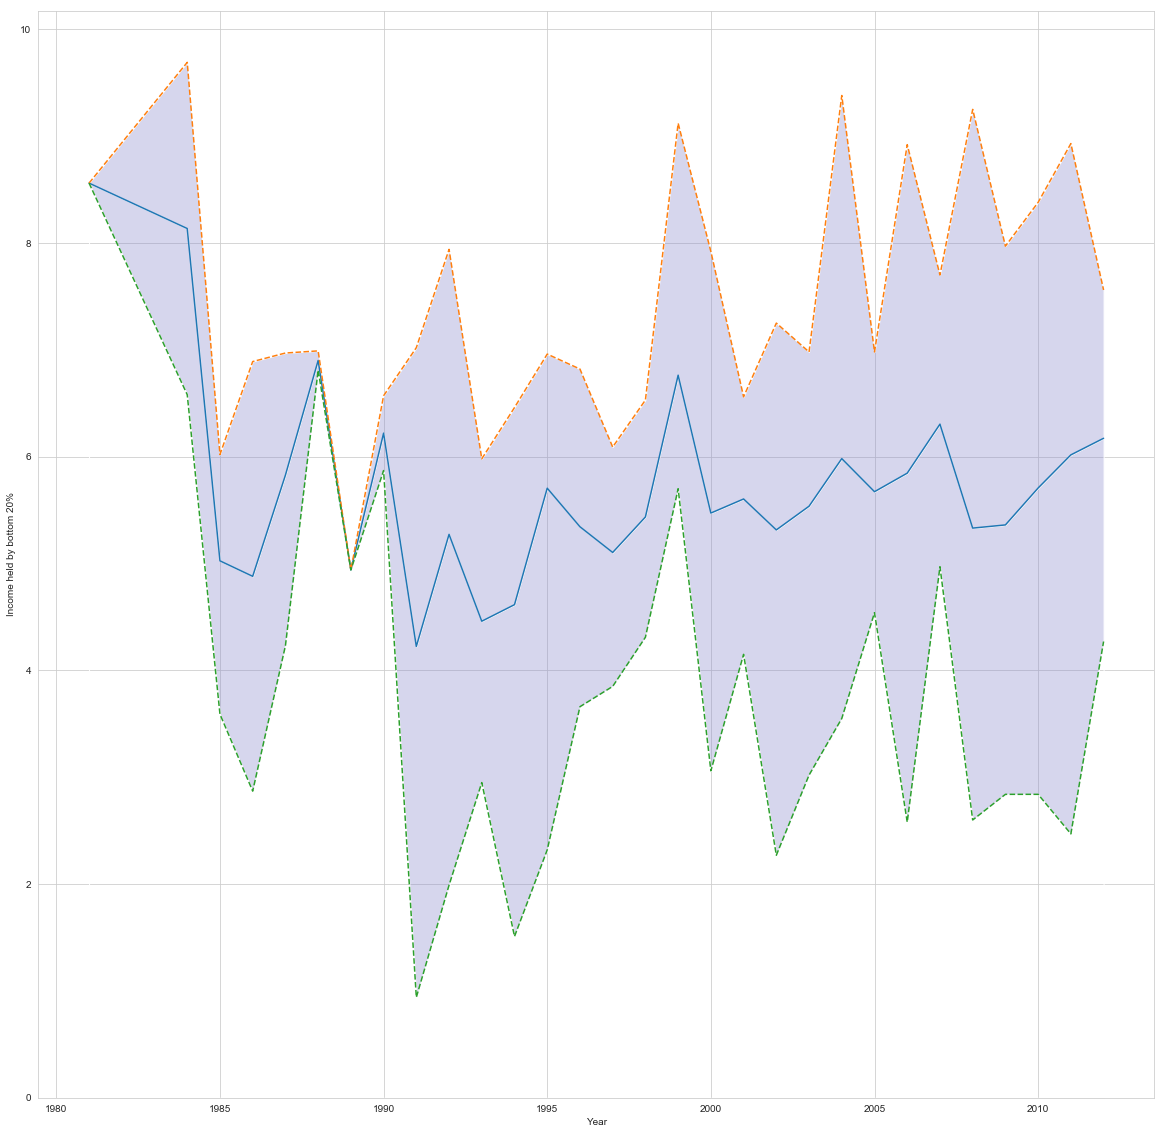

In [167]:
fig, axes = plt.subplots(figsize=(20,20))
sns.lineplot(xwealth,wealthmean['Income held by bottom 20%'],ax=axes)
sns.lineplot(xwealth,wealthmax['Income held by bottom 20%'],ax=axes)
sns.lineplot(xwealth,wealthmin['Income held by bottom 20%'],ax=axes)
axes.stackplot(xwealth,ab20,colors=[[1,1,1,0],[0.54,0.54,0.80078431, 0.35],[0.54,0.54,0.80078431, 0.35]])


plt.setp(axes.lines[1:],ls='--')


In [ ]:
axes[1].stackplot(xloc,yloc,labels=loclabels,colors=sns.cubehelix_palette(6, start=.5, rot=-.65))
axes[1].set_title('Population split between rural and urban for the World, values % of total')
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[::-1],labels[::-1],loc=4)

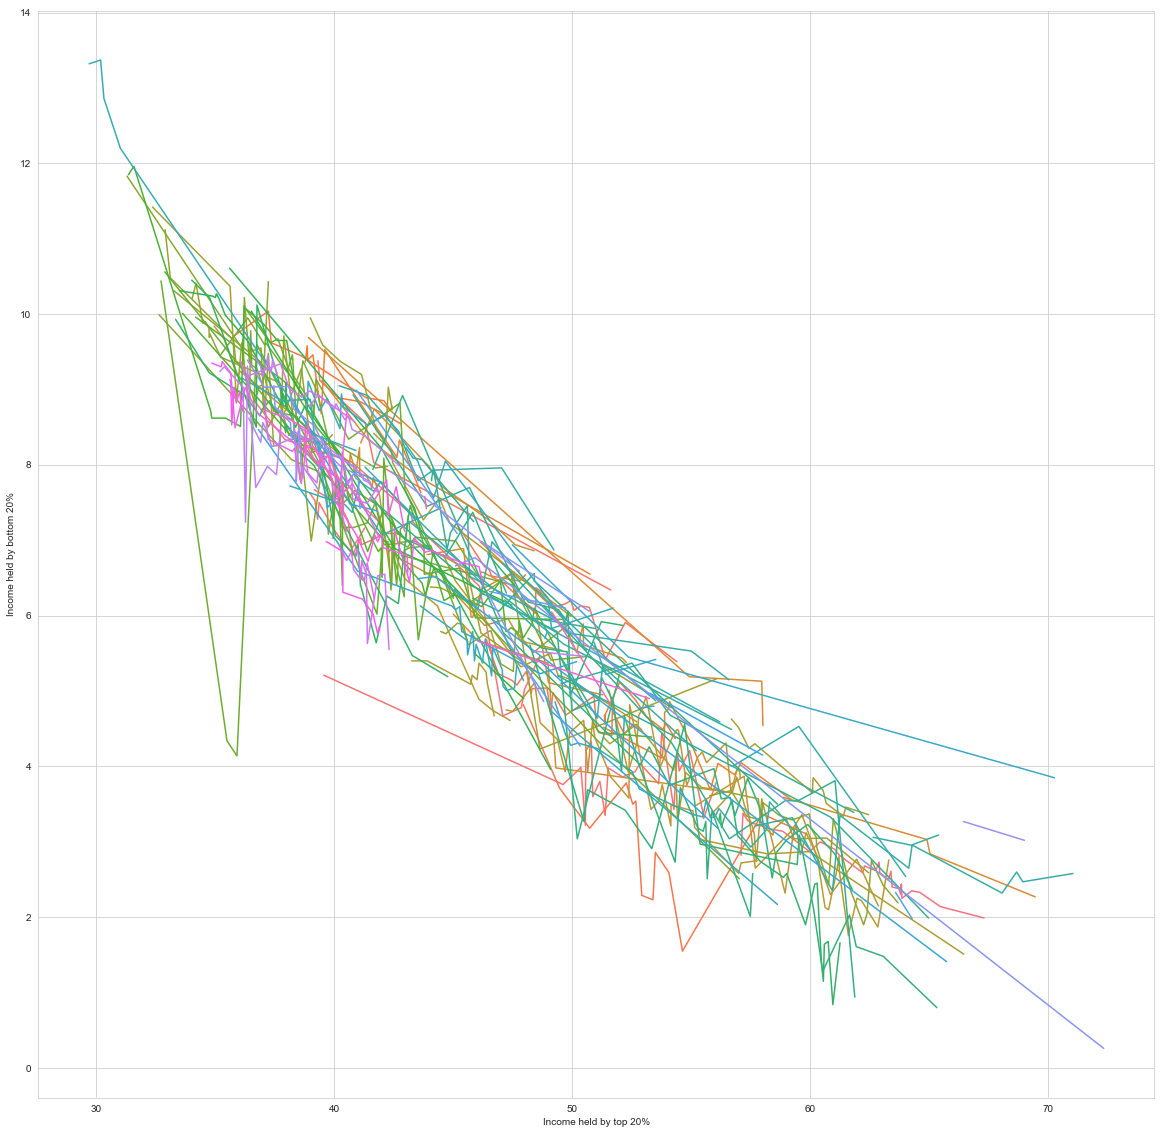

In [27]:
plt.figure(figsize=(20,20))
sns.lineplot(x='Income held by top 20%',y='Income held by bottom 20%',hue='Country Name',legend=False,data=wealthdisparity)

In [26]:
plt.figure(figsize=(20,20))
sns.lineplot(x='Year',y='ValueT20%',hue='Country Name',data=wealthdisparity)

ValueError: Could not interpret input 'ValueT20%'

<Figure size 1440x1440 with 0 Axes>

In [ ]:
wealthdisparity[wealthdisparity['Country Name']=='Malawi']

In [ ]:
fmri = sns.load_dataset("fmri")

In [ ]:
sns.lineplot(x="timepoint", y="signal",hue="event", style="event",markers=True, dashes=False, data=fmri)

In [ ]:
fmri